In [ ]:
# Quick Start: Load saved model and set up for verification
# This cell loads your saved model without needing to run all training cells

import tensorflow as tf
import cv2
import os
import numpy as np
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Define L1Dist custom layer (required for loading the model)
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
       
    def call(self, input_embedding, validation_embedding):
        # Ensure inputs are tensors, not lists
        if isinstance(input_embedding, (list, tuple)):
            input_embedding = input_embedding[0] if len(input_embedding) > 0 else input_embedding
        if isinstance(validation_embedding, (list, tuple)):
            validation_embedding = validation_embedding[0] if len(validation_embedding) > 0 else validation_embedding
        return tf.math.abs(input_embedding - validation_embedding)

# Define preprocess function (required for verification)
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    # Return image
    return img

# Set up paths (adjust if your paths are different)
ANC_PATH = os.path.join('data', 'anchor')
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')

# Load the saved model
print("Loading saved model...")
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})
print("✓ Model loaded successfully!")

# Create application_data directory structure
os.makedirs('application_data', exist_ok=True)
os.makedirs(os.path.join('application_data', 'verification_images'), exist_ok=True)
os.makedirs(os.path.join('application_data', 'input_image'), exist_ok=True)

# Copy anchor images to verification folder (if not already done)
import shutil
verification_images_path = os.path.join('application_data', 'verification_images')

if os.path.exists(ANC_PATH) and len(os.listdir(ANC_PATH)) > 0:
    anchor_files = [f for f in os.listdir(ANC_PATH) if f.endswith('.jpg')][:10]
    if len(anchor_files) > 0:
        print(f"\nCopying {len(anchor_files)} anchor images to verification folder...")
        for file_name in anchor_files:
            src = os.path.join(ANC_PATH, file_name)
            dst = os.path.join(verification_images_path, file_name)
            if not os.path.exists(dst):  # Only copy if doesn't exist
                shutil.copy2(src, dst)
        print(f"✓ Verification images ready: {len([f for f in os.listdir(verification_images_path) if f.endswith('.jpg')])} images")
else:
    print("Warning: ANC_PATH not found or empty. Please collect anchor images first.")

print("\n✓ Setup complete! You can now use the verification cells.")


1. Setup

In [27]:
!pip install tensorflow opencv-python matplotlib

1.2 Import Dependencies

In [47]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [48]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

1.3 Set GPU Growth

In [49]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

1.4 Create Folder Structures

In [31]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [32]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: 'data\\positive'

2. Collect Positives and Anchors

2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
#link of the wild dataset
# https://www.kaggle.com/datasets/jessicali9530/lfw-dataset?resource=download

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

2.2 Collect Positive and Anchor Classes

In [50]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
# Example: Generate a unique filename for anchor images
# This is just a demonstration - the actual saving happens in the camera code below
# Uncomment the line below to test (make sure ANC_PATH is defined from Cell 8 first):
# print(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())))

In [51]:
# Ensure required modules are imported
import os
import uuid
import cv2

# Ensure paths are defined (in case earlier cells weren't run)
if 'ANC_PATH' not in globals() or 'POS_PATH' not in globals():
    POS_PATH = os.path.join('data', 'positive')
    NEG_PATH = os.path.join('data', 'negative')
    ANC_PATH = os.path.join('data', 'anchor')
    # Make sure directories exist
    os.makedirs(POS_PATH, exist_ok=True)
    os.makedirs(NEG_PATH, exist_ok=True)
    os.makedirs(ANC_PATH, exist_ok=True)
    print(f"Paths initialized: ANC_PATH={ANC_PATH}, POS_PATH={POS_PATH}")
else:
    # Make sure directories exist even if paths are already defined
    os.makedirs(POS_PATH, exist_ok=True)
    os.makedirs(NEG_PATH, exist_ok=True)
    os.makedirs(ANC_PATH, exist_ok=True)

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

# Load face detection cascade (built into OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

CROP_SIZE = 250  # 250x250px as required

# Fallback coordinates if face is not detected
fallback_x = 200
fallback_y = 120

while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        break
    
    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    
    # Create a copy of the full frame for display
    display_frame = frame.copy()
    
    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # Initialize crop coordinates with fallback values
    x_start = fallback_x
    y_start = fallback_y
    
    # If face is detected, center the crop box on the largest face
    if len(faces) > 0:
        # Get the largest face (in case multiple faces are detected)
        largest_face = max(faces, key=lambda rect: rect[2] * rect[3])
        fx, fy, fw, fh = largest_face
        
        # Calculate center of the face
        face_center_x = fx + fw // 2
        face_center_y = fy + fh // 2
        
        # Center the crop box on the face
        x_start = face_center_x - CROP_SIZE // 2
        y_start = face_center_y - CROP_SIZE // 2
        
        # Draw a blue rectangle around the detected face
        cv2.rectangle(display_frame, (fx, fy), (fx + fw, fy + fh), (255, 0, 0), 2)
        cv2.putText(display_frame, 'Face Detected', (fx, fy - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    # Ensure crop coordinates are within frame bounds
    # Make sure we don't exceed frame boundaries
    x_start = max(0, min(x_start, frame_width - CROP_SIZE))
    y_start = max(0, min(y_start, frame_height - CROP_SIZE))
    
    # Check if we have enough space for the crop
    if x_start + CROP_SIZE > frame_width:
        x_start = max(0, frame_width - CROP_SIZE)
    if y_start + CROP_SIZE > frame_height:
        y_start = max(0, frame_height - CROP_SIZE)
    
    x_end = x_start + CROP_SIZE
    y_end = y_start + CROP_SIZE
    
    # Draw green rectangle on display frame to show the capture region
    cv2.rectangle(display_frame, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)
    
    # Add text labels
    cv2.putText(display_frame, 'Capture Region (250x250px)', 
                (x_start, y_start - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(display_frame, 'Press "a" for anchor, "p" for positive, "q" to quit', 
                (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Show status
    if len(faces) > 0:
        cv2.putText(display_frame, 'Face detected - Ready to capture!', 
                    (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    else:
        cv2.putText(display_frame, 'No face detected - Using fallback position', 
                    (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Show the full frame with rectangle overlay (not the cropped version)
    cv2.imshow('Image Collection', display_frame)
    
    # Crop the region for saving (250x250px) - prepare it once per frame
    cropped_frame = None
    if x_end <= frame_width and y_end <= frame_height and x_end > x_start and y_end > y_start:
        cropped_frame = frame[y_start:y_end, x_start:x_end, :]
        # Verify crop size
        if cropped_frame.shape[0] != CROP_SIZE or cropped_frame.shape[1] != CROP_SIZE:
            cropped_frame = None  # Invalid crop, don't use it
    
    # Get key press - single call per frame (like reference implementation)
    key = cv2.waitKey(1) & 0xFF
    
    # Collect anchors 
    if key == ord('a'):
        if cropped_frame is not None:
            # Create the unique file path 
            imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
            # Write out anchor image (cropped 250x250px)
            cv2.imwrite(imgname, cropped_frame)
            print(f"Anchor saved: {imgname}")
        else:
            print("Warning: Cannot save - invalid crop region")
    
    # Collect positives
    if key == ord('p'):
        if cropped_frame is not None:
            # Create the unique file path 
            imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
            # Write out positive image (cropped 250x250px)
            cv2.imwrite(imgname, cropped_frame)
            print(f"Positive saved: {imgname}")
        else:
            print("Warning: Cannot save - invalid crop region")
    
    # Breaking gracefully
    if key == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

Anchor saved: data\anchor\c7e9692d-e1df-11f0-8d1f-1cbfceacf4c2.jpg
Anchor saved: data\anchor\c838209a-e1df-11f0-8e27-1cbfceacf4c2.jpg
Anchor saved: data\anchor\c88c831d-e1df-11f0-aed2-1cbfceacf4c2.jpg
Anchor saved: data\anchor\c8e03b72-e1df-11f0-a862-1cbfceacf4c2.jpg
Anchor saved: data\anchor\c92dd10d-e1df-11f0-8e52-1cbfceacf4c2.jpg
Anchor saved: data\anchor\c96cd5d2-e1df-11f0-8175-1cbfceacf4c2.jpg
Anchor saved: data\anchor\c9ba539c-e1df-11f0-a5d8-1cbfceacf4c2.jpg
Anchor saved: data\anchor\ca148446-e1df-11f0-988a-1cbfceacf4c2.jpg
Anchor saved: data\anchor\ca64bc12-e1df-11f0-8bef-1cbfceacf4c2.jpg
Anchor saved: data\anchor\cab6fac3-e1df-11f0-81b6-1cbfceacf4c2.jpg
Anchor saved: data\anchor\cafa2ba2-e1df-11f0-b3c3-1cbfceacf4c2.jpg
Anchor saved: data\anchor\cb3b193e-e1df-11f0-b484-1cbfceacf4c2.jpg
Anchor saved: data\anchor\cb89e33e-e1df-11f0-90d6-1cbfceacf4c2.jpg
Anchor saved: data\anchor\cbd3fff5-e1df-11f0-b082-1cbfceacf4c2.jpg
Anchor saved: data\anchor\cc31673c-e1df-11f0-9758-1cbfceacf4c2

2.x NEW - Data Augmentation


In [52]:
def data_aug(img):
    """
    Creates 9 augmented versions of an image with random transformations.
    This helps the model learn to recognize faces under different conditions.
    """
    data = []
    for i in range(9):
        # Start with a copy of the original image for each augmentation
        aug_img = tf.cast(img, tf.float32) / 255.0  # Convert to float and normalize
        
        # Apply random transformations
        aug_img = tf.image.stateless_random_brightness(aug_img, max_delta=0.02, seed=(i, 2))
        aug_img = tf.image.stateless_random_contrast(aug_img, lower=0.6, upper=1, seed=(i, 3))
        aug_img = tf.image.stateless_random_flip_left_right(aug_img, seed=(np.random.randint(100), np.random.randint(100)))
        aug_img = tf.image.stateless_random_jpeg_quality(aug_img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100), np.random.randint(100)))
        aug_img = tf.image.stateless_random_saturation(aug_img, lower=0.9, upper=1, seed=(np.random.randint(100), np.random.randint(100)))
        
        # Convert back to uint8 for saving
        aug_img = tf.cast(aug_img * 255.0, tf.uint8)
        data.append(aug_img)
    
    return data


In [53]:
# Apply data augmentation to anchor images
# This creates 9 variations of each anchor image (brightness, contrast, flip, etc.)
# WARNING: This will multiply your anchor images by 9, so make sure you have enough space!

# First, get a list of all anchor images before augmentation
anchor_files = [f for f in os.listdir(ANC_PATH) if f.endswith('.jpg')]

if len(anchor_files) > 0:
    print(f"Found {len(anchor_files)} anchor images. Starting augmentation...")
    for file_name in anchor_files:
        img_path = os.path.join(ANC_PATH, file_name)
        img = cv2.imread(img_path)
        if img is not None:
            augmented_images = data_aug(img)
            for image in augmented_images:
                cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())
    print("Anchor augmentation complete!")
else:
    print("No anchor images found. Please collect anchor images first!")


Found 60 anchor images. Starting augmentation...
Anchor augmentation complete!


In [54]:
# Apply data augmentation to positive images
# This creates 9 variations of each positive image

positive_files = [f for f in os.listdir(POS_PATH) if f.endswith('.jpg')]

if len(positive_files) > 0:
    print(f"Found {len(positive_files)} positive images. Starting augmentation...")
    for file_name in positive_files:
        img_path = os.path.join(POS_PATH, file_name)
        img = cv2.imread(img_path)
        if img is not None:
            augmented_images = data_aug(img) 
            for image in augmented_images:
                cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())
    print("Positive augmentation complete!")
else:
    print("No positive images found. Please collect positive images first!")


Found 79 positive images. Starting augmentation...
Positive augmentation complete!


# 3. Load and Preprocess Images


## 3.1 Get Image Directories


In [55]:
# Calculate anchor count first (needed to limit all datasets to same length)
anchor_count = len([f for f in os.listdir(ANC_PATH) if f.endswith('.jpg')])
positive_count = len([f for f in os.listdir(POS_PATH) if f.endswith('.jpg')])
negative_count = len([f for f in os.listdir(NEG_PATH) if f.endswith('.jpg')])

print(f"Found {anchor_count} anchor, {positive_count} positive, {negative_count} negative images")

# Load image file paths into TensorFlow datasets
# Limit all datasets to anchor_count to ensure they match when zipping
# Note: Using forward slashes or os.path.join for cross-platform compatibility
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(anchor_count)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(anchor_count)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(anchor_count)

print("Datasets created with matching lengths!")


Found 600 anchor, 790 positive, 13233 negative images
Datasets created with matching lengths!


In [56]:
# Test that we can read from the anchor dataset
dir_test = anchor.as_numpy_iterator()
print("Sample anchor image path:", dir_test.next())


Sample anchor image path: b'data\\anchor\\29d317f5-e1e0-11f0-8251-1cbfceacf4c2.jpg'


## 3.2 Preprocessing - Scale and Resize


In [57]:
def preprocess(file_path):
    """
    Preprocesses an image:
    1. Reads image from file path
    2. Decodes JPEG
    3. Resizes to 100x100 pixels (required input size for the model)
    4. Normalizes pixel values to range [0, 1]
    """
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img


In [58]:
# Test the preprocessing function
# Get a sample anchor image path
sample_path = anchor.as_numpy_iterator().next().decode('utf-8')
img = preprocess(sample_path)

print(f"Preprocessed image shape: {img.shape}")
print(f"Max pixel value (should be 1.0): {img.numpy().max()}")
print(f"Min pixel value (should be 0.0): {img.numpy().min()}")


Preprocessed image shape: (100, 100, 3)
Max pixel value (should be 1.0): 0.9424019455909729
Min pixel value (should be 0.0): 0.0


## 3.3 Create Labelled Dataset


In [59]:
# Create labeled pairs for training:
# - (anchor, positive) pairs => label = 1 (same person, should be similar)
# - (anchor, negative) pairs => label = 0 (different person, should be different)

# Ensure anchor_count is available (should be from Cell 24)
if 'anchor_count' not in globals():
    anchor_count = len([f for f in os.listdir(ANC_PATH) if f.endswith('.jpg')])
    print(f"Calculated anchor_count: {anchor_count}")

# IMPORTANT: Recreate anchor dataset for negatives since it gets consumed in the first zip
# Zip anchor and positive images with label 1
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(anchor_count))))

# Recreate anchor dataset for negatives (anchor was consumed in the positives zip)
anchor_neg = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(anchor_count)
# Zip anchor and negative images with label 0  
negatives = tf.data.Dataset.zip((anchor_neg, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(anchor_count))))

# Combine both datasets
data = positives.concatenate(negatives)

print("Labeled dataset created!")


Labeled dataset created!


In [60]:
# Test the dataset structure
samples = data.as_numpy_iterator()
example = samples.next()
print(f"Anchor path: {example[0]}")
print(f"Comparison path: {example[1]}")
print(f"Label (1=same person, 0=different): {example[2]}")


Anchor path: b'data\\anchor\\2ae72daf-e1e0-11f0-8e1f-1cbfceacf4c2.jpg'
Comparison path: b'data\\positive\\300a17a1-e1e0-11f0-9479-1cbfceacf4c2.jpg'
Label (1=same person, 0=different): 1.0


## 3.4 Build Train and Test Partition


In [61]:
def preprocess_twin(input_img, validation_img, label):
    """
    Preprocesses a pair of images and returns them with their label.
    This function is used to preprocess the anchor-comparison pairs.
    """
    return (preprocess(input_img), preprocess(validation_img), label)


In [62]:
# Test preprocess_twin function
res = preprocess_twin(*example)
print(f"Anchor image shape: {res[0].shape}")
print(f"Validation image shape: {res[1].shape}")
print(f"Label: {res[2]}")


Anchor image shape: (100, 100, 3)
Validation image shape: (100, 100, 3)
Label: 1.0


In [63]:
# Use anchor_count from Cell 30 (if not defined, calculate it)
if 'anchor_count' not in globals():
    anchor_count = len([f for f in os.listdir(ANC_PATH) if f.endswith('.jpg')])
    print(f"Calculated anchor_count: {anchor_count}")

# Build dataloader pipeline
# 1. Preprocess all image pairs
data = data.map(preprocess_twin)
# 2. Cache in memory for faster access
data = data.cache()
# 3. Shuffle the data randomly
data = data.shuffle(buffer_size=10000)

# Calculate dataset length (anchor_count * 2 because we have positive and negative pairs)
data_length = anchor_count * 2
print(f"Total data samples: {data_length}")

print("Data pipeline prepared!")


Total data samples: 1200
Data pipeline prepared!


In [64]:
# Split data: 70% training, 30% testing
train_size = round(data_length * 0.7)

# Training partition
train_data = data.take(train_size)
train_data = train_data.batch(16)  # Batch size of 16
train_data = train_data.prefetch(8)  # Prefetch 8 batches for efficiency

# Testing partition  
test_data = data.skip(train_size)
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

print(f"Training samples: {train_size}")
print(f"Testing samples: {data_length - train_size}")


Training samples: 840
Testing samples: 360


# 4. Model Engineering


## 4.1 Build Embedding Layer


In [ ]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    # Return model with single output (not wrapped in list)
    return Model(inputs=[inp], outputs=d1, name='embedding')


In [66]:
embedding = make_embedding()
embedding.summary()


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer


In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        # Ensure inputs are tensors, not lists
        if isinstance(input_embedding, (list, tuple)):
            input_embedding = input_embedding[0] if len(input_embedding) > 0 else input_embedding
        if isinstance(validation_embedding, (list, tuple)):
            validation_embedding = validation_embedding[0] if len(validation_embedding) > 0 else validation_embedding
        return tf.math.abs(input_embedding - validation_embedding)


## 4.3 Make Siamese Model


In [71]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Get embeddings for both images
    # Ensure we get the tensor output, not a list or tuple
    inp_embedding = embedding(input_image)
    val_embedding = embedding(validation_image)
    
    # If embedding returns a list or tuple, extract the tensor
    if isinstance(inp_embedding, (list, tuple)):
        inp_embedding = inp_embedding[0] if len(inp_embedding) > 0 else inp_embedding
    if isinstance(val_embedding, (list, tuple)):
        val_embedding = val_embedding[0] if len(val_embedding) > 0 else val_embedding
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(inp_embedding, val_embedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [72]:
siamese_model = make_siamese_model()
siamese_model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[4][0],  │
│                     │                   │            │ embedding[5][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training


## 5.1 Setup Loss and Optimizer


In [73]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)  # 0.0001


## 5.2 Establish Checkpoints


In [74]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


## 5.3 Build Train Step Function


In [75]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss


## 5.4 Build Training Loop


In [76]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


In [77]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)


## 5.5 Train the model


In [78]:
EPOCHS = 50
train(train_data, EPOCHS)



 Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━

# 6. Evaluate Model


## 6.1 Import Metrics


In [79]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


## 6.2 Make Predictions


In [80]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# Make predictions
y_hat = siamese_model.predict([test_input, test_val])

# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


[1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0]

## 6.3 Calculate Metrics


In [92]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat) 

print(r.result().numpy(), p.result().numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1.0 1.0


## 6.4 Viz Results


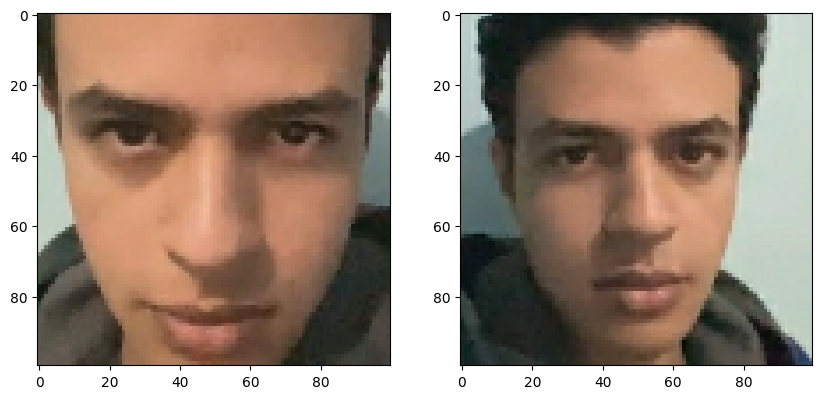

In [93]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()


# 7. Save Model


In [83]:
# Save weights
siamese_model.save('siamesemodelv2.h5')


In [ ]:
# Reload model 
# First, define L1Dist class (required for loading the model)
from tensorflow.keras.layers import Layer
import tensorflow as tf

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
       
    def call(self, input_embedding, validation_embedding):
        # Ensure inputs are tensors, not lists
        if isinstance(input_embedding, (list, tuple)):
            input_embedding = input_embedding[0] if len(input_embedding) > 0 else input_embedding
        if isinstance(validation_embedding, (list, tuple)):
            validation_embedding = validation_embedding[0] if len(validation_embedding) > 0 else validation_embedding
        return tf.math.abs(input_embedding - validation_embedding)

# Now reload the model
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})
print("✓ Model reloaded successfully!")


# 8. Real Time Test


## 8.1 Verification Function


In [ ]:
# Create application_data directory structure
os.makedirs('application_data', exist_ok=True)
os.makedirs(os.path.join('application_data', 'verification_images'), exist_ok=True)
os.makedirs(os.path.join('application_data', 'input_image'), exist_ok=True)

# Helper: Copy some anchor images to verification_images folder for testing
# This sets up your verification images - ALWAYS run this cell before verification!
import shutil
verification_images_path = os.path.join('application_data', 'verification_images')

# Check if ANC_PATH is defined
if 'ANC_PATH' not in globals():
    print("ERROR: ANC_PATH is not defined. Please run the cells that set up ANC_PATH first.")
else:
    # Get list of anchor images
    if os.path.exists(ANC_PATH):
        anchor_files = [f for f in os.listdir(ANC_PATH) if f.endswith('.jpg')]
        
        if len(anchor_files) == 0:
            print("ERROR: No anchor images found in ANC_PATH. Please collect anchor images first!")
        else:
            # Clear existing verification images first
            existing_files = [f for f in os.listdir(verification_images_path) if f.endswith('.jpg')]
            if existing_files:
                print(f"Clearing {len(existing_files)} existing verification images...")
                for f in existing_files:
                    os.remove(os.path.join(verification_images_path, f))
            
            # Copy 10 anchor images to verification folder (or all if less than 10)
            num_to_copy = min(10, len(anchor_files))
            anchor_files_to_copy = anchor_files[:num_to_copy]
            
            print(f"Copying {num_to_copy} anchor images to verification folder...")
            for file_name in anchor_files_to_copy:
                src = os.path.join(ANC_PATH, file_name)
                dst = os.path.join(verification_images_path, file_name)
                try:
                    shutil.copy2(src, dst)
                except Exception as e:
                    print(f"  Warning: Could not copy {file_name}: {e}")
            
            # Verify the copy worked
            copied_files = [f for f in os.listdir(verification_images_path) if f.endswith('.jpg')]
            print(f"✓ Successfully copied {len(copied_files)} anchor images to verification_images folder")
            print(f"  Verification images ready: {len(copied_files)} images")
            print(f"  Location: {os.path.abspath(verification_images_path)}")
    else:
        print(f"ERROR: ANC_PATH directory does not exist: {ANC_PATH}")


In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    verification_images_path = os.path.join('application_data', 'verification_images')
    
    # Check if verification images exist, if not try to auto-setup
    if not os.path.exists(verification_images_path) or len(os.listdir(verification_images_path)) == 0:
        print("Warning: No verification images found. Attempting to auto-setup...")
        # Try to auto-setup verification images from anchor folder
        if 'ANC_PATH' in globals() and os.path.exists(ANC_PATH):
            import shutil
            anchor_files = [f for f in os.listdir(ANC_PATH) if f.endswith('.jpg')][:10]
            if len(anchor_files) > 0:
                print(f"  Auto-copying {len(anchor_files)} anchor images...")
                for file_name in anchor_files:
                    src = os.path.join(ANC_PATH, file_name)
                    dst = os.path.join(verification_images_path, file_name)
                    try:
                        shutil.copy2(src, dst)
                    except:
                        pass
                # Check again
                if len(os.listdir(verification_images_path)) == 0:
                    print("Error: Auto-setup failed. Please run Cell 72 manually to copy anchor images.")
                    return [], False
                else:
                    print(f"  ✓ Auto-setup successful! {len(os.listdir(verification_images_path))} images ready.")
            else:
                print("Error: No anchor images found in ANC_PATH. Please collect anchor images first!")
                return [], False
        else:
            print("Error: No verification images found in application_data/verification_images/")
            print("Please run Cell 72 to copy some of your anchor images to that folder!")
            return [], False
    
    input_img_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
    if not os.path.exists(input_img_path):
        print("Error: Input image not found!")
        return [], False
    
    # Preprocess input image once
    input_img = preprocess(input_img_path)
    
    # Get list of verification images
    verification_images = [img for img in os.listdir(verification_images_path) 
                          if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(verification_images) == 0:
        print("Error: No valid image files in verification_images folder!")
        return [], False
    
    for image in verification_images:
        validation_img_path = os.path.join(verification_images_path, image)
        validation_img = preprocess(validation_img_path)
        
        # Make Predictions - model expects [input_img, validation_img] as separate inputs
        # The model expects batched inputs: (batch_size, 100, 100, 3)
        # Expand dimensions to add batch dimension: (100,100,3) -> (1,100,100,3)
        input_batch = np.expand_dims(input_img, axis=0)
        validation_batch = np.expand_dims(validation_img, axis=0)
        
        # Call model - returns shape (1, 1) for sigmoid output
        result = model.predict([input_batch, validation_batch], verbose=0)
        # Extract the scalar prediction value
        prediction_value = float(result[0][0])
        results.append(prediction_value)
    
    # Convert to numpy array
    results = np.array(results)
    
    # Detection Threshold: Metric above which a prediction is considered positive 
    # For Siamese network: prediction close to 1.0 means "same person"
    detection = np.sum(results > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(results) if len(results) > 0 else 0
    verified = verification > verification_threshold
    
    # Debug output
    print(f"\n{'='*50}")
    print(f"Verification Debug:")
    print(f"  Number of verification images: {len(results)}")
    print(f"  Prediction values: {results}")
    print(f"  Min prediction: {results.min():.4f}")
    print(f"  Max prediction: {results.max():.4f}")
    print(f"  Mean prediction: {results.mean():.4f}")
    print(f"  Predictions > {detection_threshold}: {detection}/{len(results)}")
    print(f"  Verification ratio: {verification:.2f} (need > {verification_threshold})")
    print(f"  Result: {'✓ VERIFIED' if verified else '✗ NOT VERIFIED'}")
    print(f"{'='*50}\n")
    
    return results, verified


## 8.1.1 Test Verification Function


In [ ]:
# Test verification function with anchor images
# This helps debug why verification might be failing

# First, make sure we have verification images
verification_images_path = os.path.join('application_data', 'verification_images')
if len(os.listdir(verification_images_path)) == 0:
    print("No verification images found. Run Cell 72 first to copy anchor images.")
else:
    # Test 1: Use the SAME anchor image as both input and verification
    # This should give very high prediction (close to 1.0) since it's identical
    test_anchor = os.listdir(ANC_PATH)[0]  # Get first anchor image
    test_input_path = os.path.join(ANC_PATH, test_anchor)
    test_verification_path = os.path.join(verification_images_path, os.listdir(verification_images_path)[0])
    
    # Copy anchor to input_image folder for testing
    import shutil
    shutil.copy2(test_input_path, os.path.join('application_data', 'input_image', 'input_image.jpg'))
    
    print("="*60)
    print("TEST 1: Same image (should give prediction ~1.0)")
    print("="*60)
    print(f"  Input: {test_anchor}")
    print(f"  Verification: {os.path.basename(test_verification_path)}")
    
    # Test prediction directly
    input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
    validation_img = preprocess(test_verification_path)
    
    print(f"  Input image shape after preprocess: {input_img.shape}")
    print(f"  Validation image shape after preprocess: {validation_img.shape}")
    print(f"  Input image range: [{input_img.numpy().min():.3f}, {input_img.numpy().max():.3f}]")
    print(f"  Validation image range: [{validation_img.numpy().min():.3f}, {validation_img.numpy().max():.3f}]")
    
    input_batch = np.expand_dims(input_img, axis=0)
    validation_batch = np.expand_dims(validation_img, axis=0)
    
    test_result = siamese_model.predict([input_batch, validation_batch], verbose=0)
    print(f"\n  Direct prediction: {test_result[0][0]:.4f}")
    print(f"  (Should be > 0.5 for matching faces, ideally > 0.7)")
    
    # Test 2: Compare two different anchor images (should still be high if same person)
    if len(os.listdir(ANC_PATH)) > 1:
        test_anchor2 = os.listdir(ANC_PATH)[1]
        shutil.copy2(os.path.join(ANC_PATH, test_anchor2), 
                     os.path.join('application_data', 'input_image', 'input_image.jpg'))
        
        print("\n" + "="*60)
        print("TEST 2: Different anchor images (same person)")
        print("="*60)
        input_img2 = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        input_batch2 = np.expand_dims(input_img2, axis=0)
        test_result2 = siamese_model.predict([input_batch2, validation_batch], verbose=0)
        print(f"  Prediction: {test_result2[0][0]:.4f}")
        print(f"  (Should be > 0.5 for same person)")
    
    # Test 3: Full verify function
    print("\n" + "="*60)
    print("TEST 3: Full verify function")
    print("="*60)
    # Use first anchor as input
    shutil.copy2(test_input_path, os.path.join('application_data', 'input_image', 'input_image.jpg'))
    results, verified = verify(siamese_model, detection_threshold=0.3, verification_threshold=0.3)


## 8.2.1 Complete Real-Time Verification (Self-Contained)
**Use this cell instead of the one above - it loads the model automatically**


In [ ]:
# ============================================================================
# REAL-TIME VERIFICATION - COMPLETE SETUP (Self-contained cell)
# ============================================================================
# This cell loads the saved model and sets up everything needed for verification
# You don't need to run any previous cells - just run this one!

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
import shutil

# Define L1Dist custom layer (required for loading the model)
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
       
    def call(self, input_embedding, validation_embedding):
        if isinstance(input_embedding, (list, tuple)):
            input_embedding = input_embedding[0] if len(input_embedding) > 0 else input_embedding
        if isinstance(validation_embedding, (list, tuple)):
            validation_embedding = validation_embedding[0] if len(validation_embedding) > 0 else validation_embedding
        return tf.math.abs(input_embedding - validation_embedding)

# Define preprocess function (required for verification)
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

# Define verify function
def verify(model, detection_threshold, verification_threshold):
    results = []
    verification_images_path = os.path.join('application_data', 'verification_images')
    
    if not os.path.exists(verification_images_path) or len(os.listdir(verification_images_path)) == 0:
        print("Warning: No verification images found. Attempting to auto-setup...")
        ANC_PATH = os.path.join('data', 'anchor')
        if os.path.exists(ANC_PATH) and len(os.listdir(ANC_PATH)) > 0:
            anchor_files = [f for f in os.listdir(ANC_PATH) if f.endswith('.jpg')][:10]
            if len(anchor_files) > 0:
                print(f"  Auto-copying {len(anchor_files)} anchor images...")
                for file_name in anchor_files:
                    src = os.path.join(ANC_PATH, file_name)
                    dst = os.path.join(verification_images_path, file_name)
                    try:
                        shutil.copy2(src, dst)
                    except:
                        pass
                if len(os.listdir(verification_images_path)) == 0:
                    print("Error: Auto-setup failed. Please copy anchor images to application_data/verification_images/")
                    return [], False
                else:
                    print(f"  ✓ Auto-setup successful! {len(os.listdir(verification_images_path))} images ready.")
            else:
                print("Error: No anchor images found. Please collect anchor images first!")
                return [], False
        else:
            print("Error: No verification images found. Please copy anchor images to application_data/verification_images/")
            return [], False
    
    input_img_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
    if not os.path.exists(input_img_path):
        print("Error: Input image not found!")
        return [], False
    
    input_img = preprocess(input_img_path)
    verification_images = [img for img in os.listdir(verification_images_path) 
                          if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(verification_images) == 0:
        print("Error: No valid image files in verification_images folder!")
        return [], False
    
    for image in verification_images:
        validation_img_path = os.path.join(verification_images_path, image)
        validation_img = preprocess(validation_img_path)
        
        input_batch = np.expand_dims(input_img, axis=0)
        validation_batch = np.expand_dims(validation_img, axis=0)
        
        result = model.predict([input_batch, validation_batch], verbose=0)
        prediction_value = float(result[0][0])
        results.append(prediction_value)
    
    results = np.array(results)
    detection = np.sum(results > detection_threshold)
    verification = detection / len(results) if len(results) > 0 else 0
    verified = verification > verification_threshold
    
    print(f"\n{'='*50}")
    print(f"Verification Debug:")
    print(f"  Number of verification images: {len(results)}")
    print(f"  Prediction values: {results}")
    print(f"  Min prediction: {results.min():.4f}")
    print(f"  Max prediction: {results.max():.4f}")
    print(f"  Mean prediction: {results.mean():.4f}")
    print(f"  Predictions > {detection_threshold}: {detection}/{len(results)}")
    print(f"  Verification ratio: {verification:.2f} (need > {verification_threshold})")
    print(f"  Result: {'✓ VERIFIED' if verified else '✗ NOT VERIFIED'}")
    print(f"{'='*50}\n")
    
    return results, verified

# Load the saved model
print("Loading saved model 'siamesemodelv2.h5'...")
if not os.path.exists('siamesemodelv2.h5'):
    print("ERROR: Model file 'siamesemodelv2.h5' not found!")
    print("Please make sure the model file is in the current directory.")
    raise FileNotFoundError("Model file 'siamesemodelv2.h5' not found!")
else:
    siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                       custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})
    print("✓ Model loaded successfully!")

# Create application_data directory structure
os.makedirs('application_data', exist_ok=True)
os.makedirs(os.path.join('application_data', 'verification_images'), exist_ok=True)
os.makedirs(os.path.join('application_data', 'input_image'), exist_ok=True)

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

# Load face detection cascade (built into OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

CROP_SIZE = 250  # 250x250px as required

# Fallback coordinates if face is not detected
fallback_x = 200
fallback_y = 120

while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        break
    
    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    
    # Create a copy of the full frame for display
    display_frame = frame.copy()
    
    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # Initialize crop coordinates with fallback values
    x_start = fallback_x
    y_start = fallback_y
    
    # If face is detected, center the crop box on the largest face
    if len(faces) > 0:
        # Get the largest face (in case multiple faces are detected)
        largest_face = max(faces, key=lambda rect: rect[2] * rect[3])
        fx, fy, fw, fh = largest_face
        
        # Calculate center of the face
        face_center_x = fx + fw // 2
        face_center_y = fy + fh // 2
        
        # Center the crop box on the face
        x_start = face_center_x - CROP_SIZE // 2
        y_start = face_center_y - CROP_SIZE // 2
        
        # Draw a blue rectangle around the detected face
        cv2.rectangle(display_frame, (fx, fy), (fx + fw, fy + fh), (255, 0, 0), 2)
        cv2.putText(display_frame, 'Face Detected', (fx, fy - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    # Ensure crop coordinates are within frame bounds
    x_start = max(0, min(x_start, frame_width - CROP_SIZE))
    y_start = max(0, min(y_start, frame_height - CROP_SIZE))
    
    # Check if we have enough space for the crop
    if x_start + CROP_SIZE > frame_width:
        x_start = max(0, frame_width - CROP_SIZE)
    if y_start + CROP_SIZE > frame_height:
        y_start = max(0, frame_height - CROP_SIZE)
    
    x_end = x_start + CROP_SIZE
    y_end = y_start + CROP_SIZE
    
    # Draw green rectangle on display frame to show the capture region
    cv2.rectangle(display_frame, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)
    
    # Add text labels
    cv2.putText(display_frame, 'Capture Region (250x250px)', 
                (x_start, y_start - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(display_frame, 'Press "v" to verify, "q" to quit', 
                (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Show status
    if len(faces) > 0:
        cv2.putText(display_frame, 'Face detected - Ready to verify!', 
                    (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    else:
        cv2.putText(display_frame, 'No face detected - Using fallback position', 
                    (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Show the full frame with rectangle overlay
    cv2.imshow('Verification', display_frame)
    
    # Crop the region for verification (250x250px) - prepare it once per frame
    cropped_frame = None
    if x_end <= frame_width and y_end <= frame_height and x_end > x_start and y_end > y_start:
        cropped_frame = frame[y_start:y_end, x_start:x_end, :]
        # Verify crop size
        if cropped_frame.shape[0] != CROP_SIZE or cropped_frame.shape[1] != CROP_SIZE:
            cropped_frame = None  # Invalid crop, don't use it
    
    # Get key press
    key = cv2.waitKey(1) & 0xFF
    
    # Verification trigger
    if key == ord('v'):
        if cropped_frame is not None:
            # Ensure the cropped frame is exactly 250x250
            if cropped_frame.shape[0] != 250 or cropped_frame.shape[1] != 250:
                # Resize if needed
                cropped_frame = cv2.resize(cropped_frame, (250, 250))
            
            # Save input image to application_data/input_image folder 
            input_img_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
            cv2.imwrite(input_img_path, cropped_frame)
            
            # Verify the saved image
            saved_img = cv2.imread(input_img_path)
            if saved_img is not None:
                print(f"\nSaved image info: shape={saved_img.shape}, dtype={saved_img.dtype}")
            else:
                print("ERROR: Could not read saved image!")
            
            # Run verification with adjusted thresholds
            # Lower thresholds for more lenient verification (0.3 instead of 0.5)
            results, verified = verify(siamese_model, detection_threshold=0.3, verification_threshold=0.3)
            if verified:
                cv2.putText(display_frame, 'VERIFIED!', (10, 90), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
                print("VERIFIED: Face matches!")
            else:
                cv2.putText(display_frame, 'NOT VERIFIED', (10, 90), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
                print("NOT VERIFIED: Face does not match")
        else:
            print("Warning: Cannot verify - invalid crop region")
    
    # Breaking gracefully
    if key == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


## 8.2 OpenCV Real Time Verification


## 8.2 OpenCV Real Time Verification


In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

# Load face detection cascade (built into OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

CROP_SIZE = 250  # 250x250px as required

# Fallback coordinates if face is not detected
fallback_x = 200
fallback_y = 120

while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        break
    
    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    
    # Create a copy of the full frame for display
    display_frame = frame.copy()
    
    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # Initialize crop coordinates with fallback values
    x_start = fallback_x
    y_start = fallback_y
    
    # If face is detected, center the crop box on the largest face
    if len(faces) > 0:
        # Get the largest face (in case multiple faces are detected)
        largest_face = max(faces, key=lambda rect: rect[2] * rect[3])
        fx, fy, fw, fh = largest_face
        
        # Calculate center of the face
        face_center_x = fx + fw // 2
        face_center_y = fy + fh // 2
        
        # Center the crop box on the face
        x_start = face_center_x - CROP_SIZE // 2
        y_start = face_center_y - CROP_SIZE // 2
        
        # Draw a blue rectangle around the detected face
        cv2.rectangle(display_frame, (fx, fy), (fx + fw, fy + fh), (255, 0, 0), 2)
        cv2.putText(display_frame, 'Face Detected', (fx, fy - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    # Ensure crop coordinates are within frame bounds
    x_start = max(0, min(x_start, frame_width - CROP_SIZE))
    y_start = max(0, min(y_start, frame_height - CROP_SIZE))
    
    # Check if we have enough space for the crop
    if x_start + CROP_SIZE > frame_width:
        x_start = max(0, frame_width - CROP_SIZE)
    if y_start + CROP_SIZE > frame_height:
        y_start = max(0, frame_height - CROP_SIZE)
    
    x_end = x_start + CROP_SIZE
    y_end = y_start + CROP_SIZE
    
    # Draw green rectangle on display frame to show the capture region
    cv2.rectangle(display_frame, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)
    
    # Add text labels
    cv2.putText(display_frame, 'Capture Region (250x250px)', 
                (x_start, y_start - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(display_frame, 'Press "v" to verify, "q" to quit', 
                (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Show status
    if len(faces) > 0:
        cv2.putText(display_frame, 'Face detected - Ready to verify!', 
                    (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    else:
        cv2.putText(display_frame, 'No face detected - Using fallback position', 
                    (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Show the full frame with rectangle overlay
    cv2.imshow('Verification', display_frame)
    
    # IMPORTANT: Make sure the OpenCV window has focus - click on it!
    # Get key press - use 30ms delay for better key detection (instead of 1ms)
    key = cv2.waitKey(30) & 0xFF
    
    # Crop the region for verification (250x250px) - prepare it once per frame
    cropped_frame = None
    if x_end <= frame_width and y_end <= frame_height and x_end > x_start and y_end > y_start:
        cropped_frame = frame[y_start:y_end, x_start:x_end, :]
        # Verify crop size
        if cropped_frame.shape[0] != CROP_SIZE or cropped_frame.shape[1] != CROP_SIZE:
            cropped_frame = None  # Invalid crop, don't use it
    
    # Debug: Print key code if a key is pressed (for troubleshooting)
    if key != 255:  # 255 means no key pressed
        print(f"Key detected: {key} (char: '{chr(key) if 32 <= key <= 126 else 'non-printable'}')")
    
    # Verification trigger - check both lowercase and uppercase
    if key == ord('v') or key == ord('V'):
        if cropped_frame is not None:
            # Ensure the cropped frame is exactly 250x250
            if cropped_frame.shape[0] != 250 or cropped_frame.shape[1] != 250:
                # Resize if needed
                cropped_frame = cv2.resize(cropped_frame, (250, 250))
            
            # Save input image to application_data/input_image folder 
            input_img_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
            cv2.imwrite(input_img_path, cropped_frame)
            
            # Verify the saved image
            saved_img = cv2.imread(input_img_path)
            if saved_img is not None:
                print(f"\nSaved image info: shape={saved_img.shape}, dtype={saved_img.dtype}")
            else:
                print("ERROR: Could not read saved image!")
            
            # Run verification with adjusted thresholds
            # Lower thresholds for more lenient verification (0.3 instead of 0.5)
            results, verified = verify(siamese_model, detection_threshold=0.3, verification_threshold=0.3)
            if verified:
                cv2.putText(display_frame, 'VERIFIED!', (10, 90), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
                print("VERIFIED: Face matches!")
            else:
                cv2.putText(display_frame, 'NOT VERIFIED', (10, 90), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
                print("NOT VERIFIED: Face does not match")
        else:
            print("Warning: Cannot verify - invalid crop region")
    
    # Breaking gracefully - check for 'q', 'Q', or ESC key (27)
    if key == ord('q') or key == ord('Q') or key == 27:
        print("Quitting verification...")
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


C:\Users\Pc\AppData\Local\Temp\ipykernel_5952\1023341632.py:16: RuntimeWarning: invalid value encountered in scalar divide
  verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))


NOT VERIFIED: Face does not match
NOT VERIFIED: Face does not match
NOT VERIFIED: Face does not match
NOT VERIFIED: Face does not match
NOT VERIFIED: Face does not match
NOT VERIFIED: Face does not match


KeyboardInterrupt: 